# Notebook for comparing different marginal likelihood estimators for VAEs as well as the performance of MH when using these estimators

## Initialization

In [75]:
%load_ext autoreload
%autoreload 2
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from time import time
from tqdm import tqdm
from collections import defaultdict
from math import ceil
import statistics
import seaborn as sns

from approxmh.utilities import *
from approxmh.y_utils import *
from approxmh.samplers import *
from approxmh.distributions import Banana, Funnel, Serpentine, create_gaussian_mixture, create_gaussian_lattice, create_random_gaussian_mixture, get_mode_coverage, create_serpentine
from approxmh.distribution_metrics import *
from approxmh.sequential_mcmc import LangevinKernel, run_annealed_importance_sampling, DensityMixture
from approxmh.vae import VAE, VAETrainer, get_filename
from approxmh.gan_latent_space_distributions import SNGANLatentSpace

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)


MODEL_DIR = '../models/'

def model_file(model, target_name):
    return MODEL_DIR + get_filename(model, target_name)

def save_model(model, target_name):
    model.save_knowledge(model_file(model, target_name))

def load_model(model, target_name):
    model.load_knowledge(model_file(model, target_name))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device: cuda


## Targets

In [28]:
def plot_target(N=4000, xlim=None, ylim=None, levels=30, dpi=30, proj_dims=(0, 1), plot_samples=True):
    fixed_coordinates = torch.zeros(D)

    fig, ax = plt.subplots(figsize=(5, 5))

    if plot_samples:
        # Implementation of torch.distributions.mixture_same_family.sample() causes MemoryOverflow without batched sampling
        target_sample = sample_by_batches(target, N, batch_size=1024)[:, proj_dims]
        ax.scatter(*pl(target_sample), zorder=4, alpha=0.5, s=150, edgecolors='none', marker='.')
        if xlim is None:
            xlim = (target_sample[:, 0].min().item(), target_sample[:, 0].max().item())
        if ylim is None:
            ylim = (target_sample[:, 1].min().item(), target_sample[:, 1].max().item())

    x = torch.linspace(*xlim, dpi)
    y = torch.linspace(*ylim, dpi)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    points = fixed_coordinates.repeat(dpi * dpi, 1)
    points[:, proj_dims[0]] = X.ravel()
    points[:, proj_dims[1]] = Y.ravel()
    Z = target.log_prob(points.to(device)).reshape(dpi, dpi)
    
    ax.contour(to_numpy(X), to_numpy(Y), to_numpy(Z), levels=levels)
    # ax.imshow(to_numpy(Z), origin='lower', extent=[*xlim, *ylim], aspect='auto')
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel(f'x_{proj_dims[0]}')
    ax.set_ylabel(f'x_{proj_dims[1]}')
    ax.set_title(f'{target_friendly_name} {" (Projection)" if D > 2 else ""}')

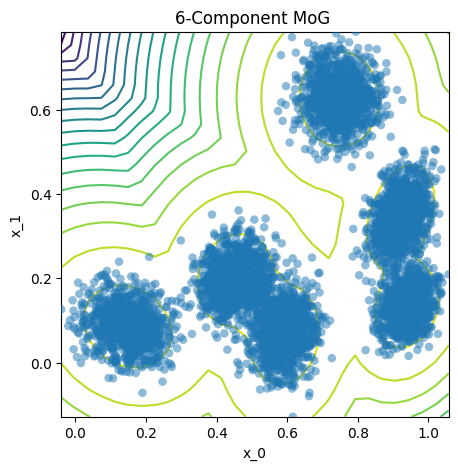

In [66]:
# Target 1
mean_lim = np.array([0, 1])
seed = 43
n_components = 6
D = 2
variance_lim = (0.001, 0.004)
target = create_random_gaussian_mixture(dim=D, n_components=n_components, mean_lim=mean_lim, variance_lim=variance_lim, device=device, seed=seed)
target_name = f'mog{n_components}_{D}d_vlim{variance_lim}_seed{seed}'
target_friendly_name = f'{n_components}-Component MoG'


plot_target(N=6_000, levels=20)
torch.cuda.empty_cache()

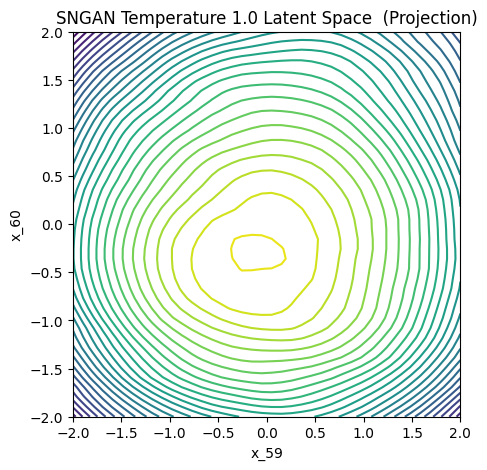

In [5]:
# Target 2
try:
    target = SNGANLatentSpace(device=device, temperature=1.0)
    D = target.latent_dim
    target_name = target.name()
    target_friendly_name = target.friendly_name()
    plot_target(N=1_000, xlim=(-2, 2), ylim=(-2, 2), levels=40, dpi=40, proj_dims=(59, 60), plot_samples=False)
except torch.cuda.OutOfMemoryError:
    print("Memory allocation failed")
    del target

torch.cuda.empty_cache()

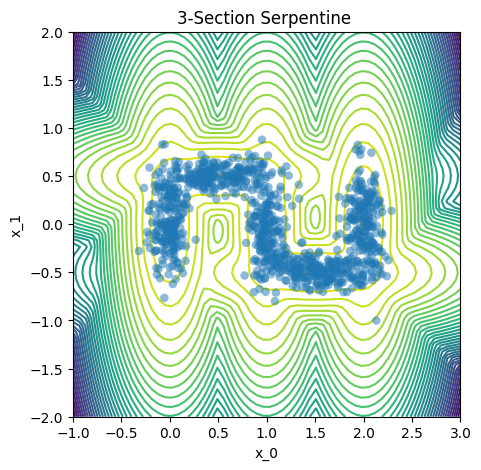

In [63]:
# Target 3
n_sections = 3
target = create_serpentine(n_sections=n_sections, section_height=1, device=device)
D = 2
target_friendly_name = f'{n_sections}-Section Serpentine'
target_name = f'serpentine{n_sections}'
plot_target(N=1000, xlim=(-1, 3), ylim=(-2, 2), levels=40, dpi=60, plot_samples=True)

## VAE Training/Loading

In [67]:
hidden_dims = (4, 4, 4, 4, 4)
vae = VAE(
    data_dim=D,
    hidden_dims=hidden_dims,
    latent_dim=D,
    device=device
)

# True -- train model, False -- load model from file
TRAIN_VAE = False

In [68]:
%%time

if TRAIN_VAE:
    x_train = target.sample((16_384,))
    print('VAE parameters:', count_parameters(vae))
    #optimizer = torch.optim.SGD(vae.parameters(), lr=0.05, momentum=0.9)
    optimizer = torch.optim.Adam(vae.parameters(), lr=0.002)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.2, step_size=250)
    trainer = VAETrainer(
        vae, target, batch_size=2048, no_kl_penalty_epochs=10, kl_annealing_epochs=100, 
        warmup_period=2, optimizer=optimizer, scheduler=scheduler, device=device
    )
    trainer.fit(x_train, n_epochs=500, plot_interval=10)
    save_model(vae, target_name)
else:
    load_model(vae, target_name)

CPU times: total: 15.6 ms
Wall time: 29 ms


## Testing SMC Estimates

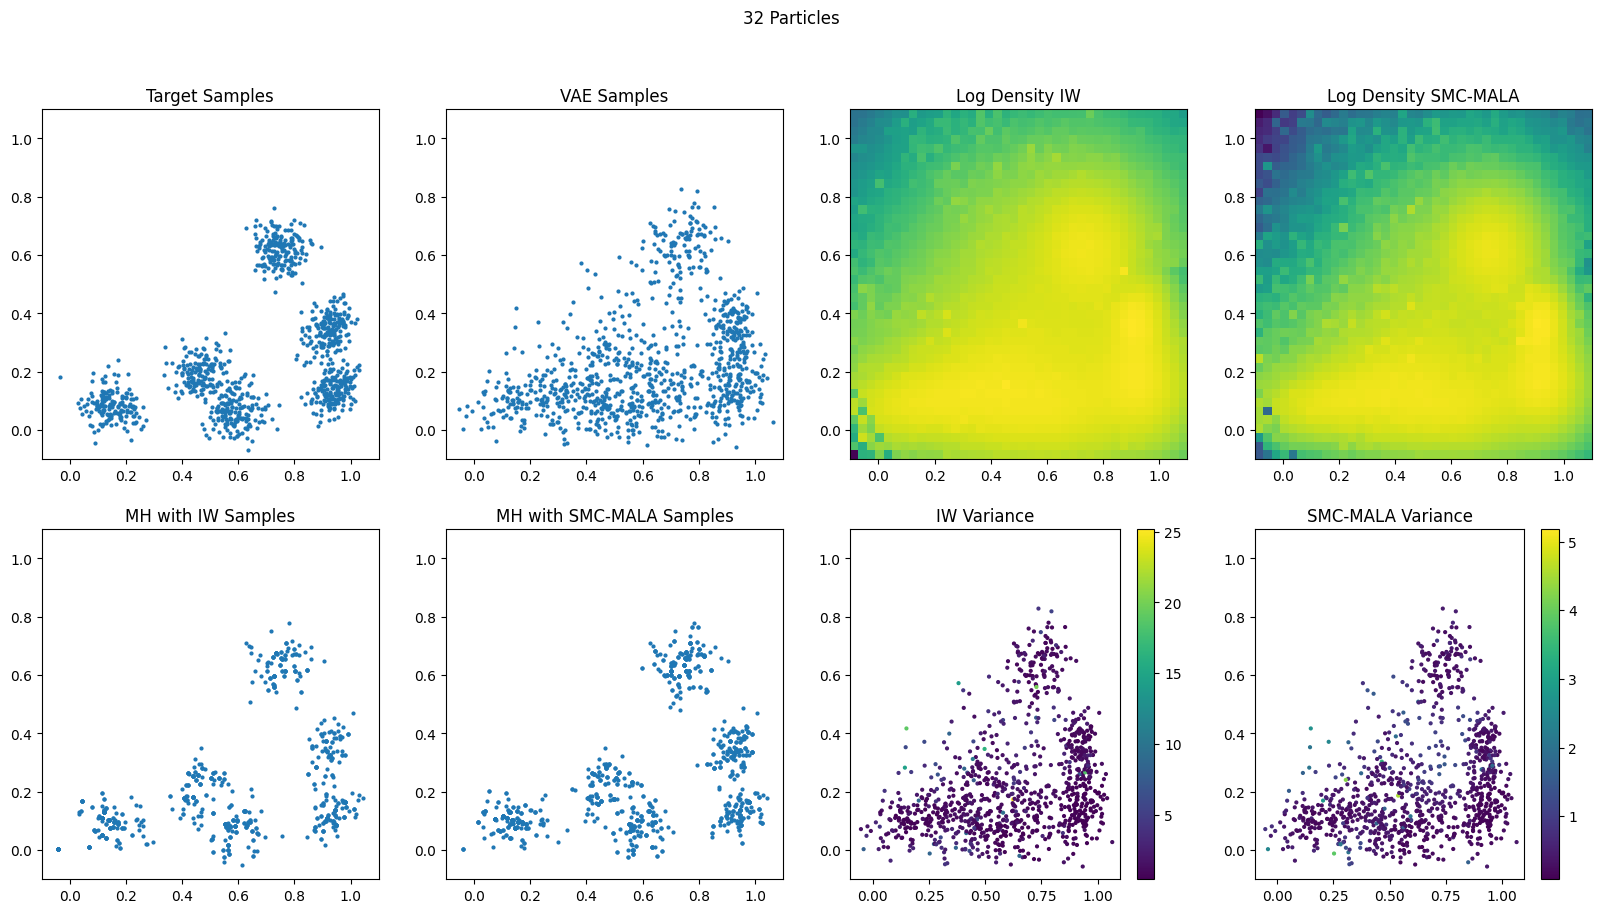

In [72]:
def compare_estimators_for_mh():
    # general parameters
    n_samples = 1000
    # SMC-ULA parameters
    n_particles = 32
    n_steps = 20
    time_step = 0.8
    # plotting params
    xlim = (-0.1, 1.1)
    ylim = (-0.1, 1.1)
    d = 40
    x = np.linspace(*xlim, d)
    y = np.linspace(*ylim, d)
    X, Y = np.meshgrid(x, y)
    points = torch.tensor(np.vstack((X.ravel(), Y.ravel())).T, dtype=torch.float).to(device)

    vae_samples = vae.sample((n_samples,))
    cutoff = get_log_prob_quantile(target, q=0)
    
    marginal_estimators = [
        ('IW', lambda x : vae.iw_log_marginal_estimate(x, L=n_particles*n_steps, batch_L=64)),
        ('SMC-MALA', lambda x: vae.ais_log_marginal_estimate(
            x, n_steps=n_steps, n_particles=n_particles, time_step=time_step, resample=False, precondition=True,
            return_acc_rate=False, kernel_type='mala'
        ))
    ]
    n_est = len(marginal_estimators)

    target_logd = target.log_prob(points).reshape(d, d)
    sc = [0, 0]
    
    fig, axs = plt.subplots(ncols=2+n_est, nrows=2, figsize=(20,10))
    fig.suptitle(f'{n_particles} Particles')
    axs = axs.flatten()
    axs[0].set_title('Target Samples')
    axs[0].scatter(*pl(target.sample((n_samples,))), s=4)
    axs[1].set_title('VAE Samples')
    axs[1].scatter(*pl(vae_samples), s=4)
    for i, (estimator_name, estimator) in enumerate(marginal_estimators):
        ax = axs[2 + i]
        ax.set_title(f'Log Density {estimator_name}')
        estimated_logd, _ = estimator(points)
        estimated_logd = estimated_logd.reshape(d, d)
        
        ax.imshow(to_numpy(estimated_logd), origin='lower', extent=[*xlim, *ylim], aspect="auto")

        ax = axs[2 + n_est + i]
        ax.set_title(f'MH with {estimator_name} Samples')
        # cut_acc_rate, cut_samples = log_prob_cutoff_filter(target, vae_samples, cutoff, return_indicies=False)
        mh_acc_rate, mh_samples = metropolis_hastings_filter(target, vae_samples, estimator)
        ax.scatter(*pl(mh_samples), s=4)

        log_likelihoods, variances = estimator(vae_samples)

        ax = axs[2 + 2 * n_est + i]
        ax.set_title(f'{estimator_name} Variance')
        sc[i] = ax.scatter(*pl(vae_samples), c=to_numpy(variances.sqrt() / torch.exp(log_likelihoods)), s=4)
        plt.colorbar(sc[i])
        # ax.imshow(to_numpy(target_logd - estimated_logd), origin='lower', extent=[*xlim, *ylim], aspect="auto")

    # unify_clim(*sc)
    
    for ax in axs:
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)

compare_estimators_for_mh()

MALA Posterior Sampling A/R: 0.617


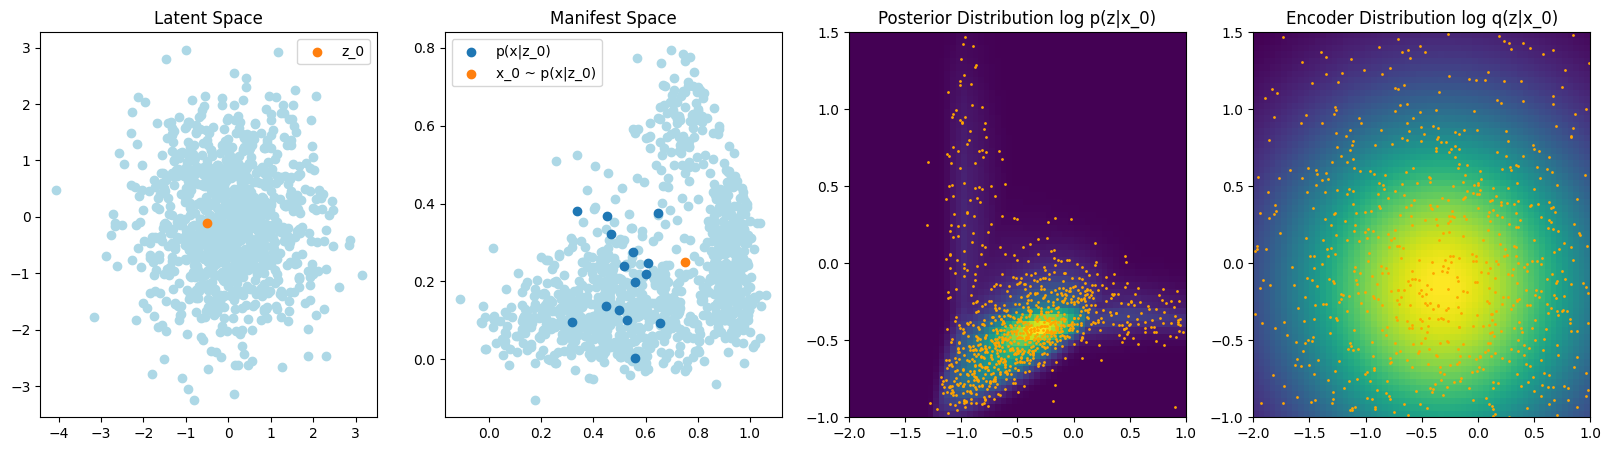

In [81]:
def one_point_analysis(show_samples=True):
    n_samples = 1000
    n_samples2 = 1000
    n_dec = 15
    latent_xlim = (-2, 1)
    latent_ylim = (-1, 1.5)
    dpi = 60
    # SIS parameters
    n_particles = 32
    n_steps = 20
    time_step = 0.08

    iw_estimate = lambda x: vae.iw_log_marginal_estimate(x, L=n_particles*n_steps, batch_L=64)
    ais_estimate = lambda x: vae.ais_log_marginal_estimate(
        x, n_steps=n_steps, n_particles=n_particles, time_step=time_step, resample=False, precondition=True,
        return_acc_rate=False, kernel_type='mala'
    )
    
    # arbitrary point in latent space
    z_0 = torch.tensor([-0.5, -0.1], device=device)
    # sample from the decoder distribution
    decoder_distribution = vae.decoder_distribution(z_0.unsqueeze(0))
    xs = decoder_distribution.sample((n_dec,)).squeeze()
    x_0 = xs[:1]
    x_0 = torch.tensor([0.75, 0.25], device=device)

    

    fig, axs = plt.subplots(ncols=4, figsize=(20, 5))
    ax = axs[0]
    ax.set_title('Latent Space')
    ax.scatter(*pl(vae.prior.sample((n_samples,))), color='lightblue')
    ax.scatter(*pl(z_0), color='tab:orange', label='z_0')

    ax = axs[1]
    ax.set_title('Manifest Space')
    ax.scatter(*pl(vae.sample((n_samples,))), color='lightblue')
    ax.scatter(*pl(xs), label='p(x|z_0)')
    ax.scatter(*pl(x_0), label='x_0 ~ p(x|z_0)')
    # ax.scatter(*pl(vae.reconstruct(x_0.unsqueeze(0))), label='Reconstruction of x_0')

    ax = axs[3]
    ax.set_title('Encoder Distribution log q(z|x_0)')
    img3 = plot_2d_torch_function(ax, vae.encoder_distribution(x_0).prob, latent_xlim, latent_ylim, dpi, device=device)
    if show_samples:
        encoder_samples = vae.encoder_distribution(x_0).sample((n_samples2,))
        ax.scatter(*pl(encoder_samples), s=1, c='orange')
        ax.set_xlim(latent_xlim)
        ax.set_ylim(latent_ylim)
    
    ax = axs[2]
    ax.set_title('Posterior Distribution log p(z|x_0)')
    img2 = plot_2d_torch_function(ax, vae.posterior(x_0).prob, latent_xlim, latent_ylim, dpi, device=device)
    if show_samples:
        n_langevin_steps = 1000
        kernel = LangevinKernel(vae.posterior(x_0), 0.025, True)
        posterior_samples = encoder_samples
        acc_rates = []
        for i in range(n_langevin_steps):
            posterior_samples, acc_rate = kernel.step(posterior_samples)
            acc_rates.append(acc_rate.mean().item())
        print(f'MALA Posterior Sampling A/R: {statistics.mean(acc_rates):0.3f}')
        ax.scatter(*pl(posterior_samples), s=1, c='orange')
        ax.set_xlim(latent_xlim)
        ax.set_ylim(latent_ylim)

    # unify_clim(img2, img3)
    
    for ax in axs[:2]:
        ax.legend()

one_point_analysis()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.07it/s]


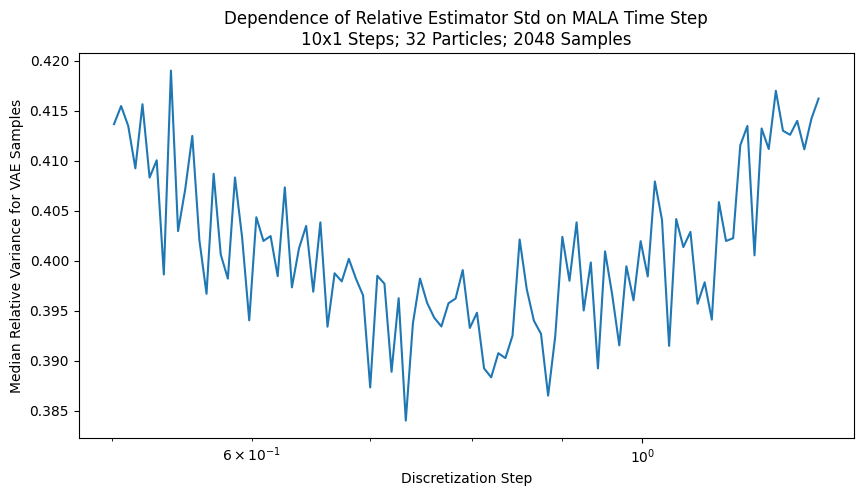

In [35]:
def vae_likelihood_estimation_variance_by_time_step():
    n_steps = 10
    n_kernel_steps = 1
    n_particles = 32
    n_samples = 2048
    time_step_options = np.logspace(-0.3, 0.1, 100)  # Langevin time step options
    kernel_type = 'mala'

    vae_samples = vae.sample((n_samples,))

    iw_log_likelihoods, iw_variances = vae.iw_log_marginal_estimate(vae_samples, L=32_768, batch_L=4096, return_variance=True)
    iw_rel_variance = (iw_variances / iw_log_likelihoods.exp()).median().item()

    test_logs = defaultdict(list)
    for time_step in tqdm(time_step_options):
        log_likelihoods, variances, acc_rates = vae.ais_log_marginal_estimate(
            vae_samples, n_steps=n_steps, n_particles=n_particles, time_step=time_step,
            kernel_type='mala', resample=False, return_acc_rate=True, precondition=True,
            n_kernel_steps=n_kernel_steps,
            annealing_scheme='linear'
        )
        test_logs['rel_variance'].append((variances.sqrt() / log_likelihoods.exp()).median().item())

    # rel_variances = torch.stack(test_logs['rel_variance'], dim=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(f'Dependence of Relative Estimator Std on {kernel_type.upper()} Time Step\n{n_steps}x{n_kernel_steps} Steps; {n_particles} Particles; {n_samples} Samples')
    ax.set_xlabel('Discretization Step')
    ax.set_xscale('log')
    ax.set_ylabel('Median Relative Variance for VAE Samples')
    # ax.set_yscale('log')
    # ax.axhline(iw_rel_variance, label='IW Estimator Median Rel. Variance', color='black', linestyle='--')
    ax.plot(time_step_options, test_logs['rel_variance'], color='tab:blue', alpha=1)
    # ax.legend()

vae_likelihood_estimation_variance_by_time_step()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


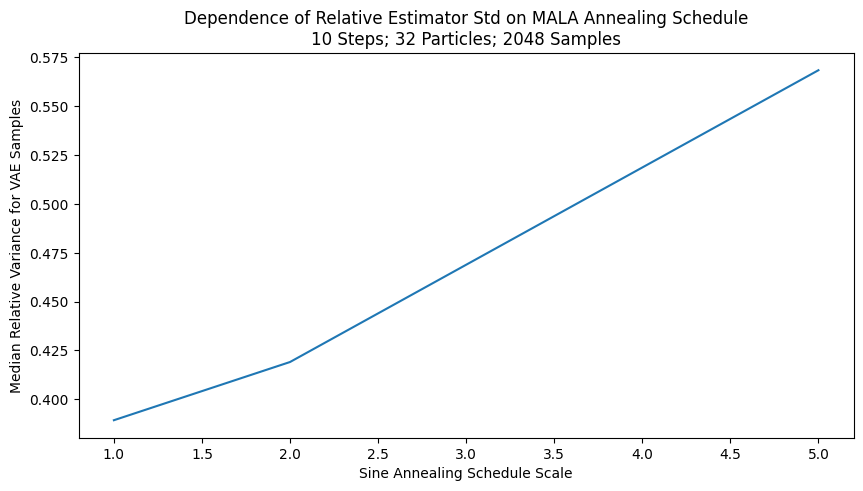

In [32]:
def vae_likelihood_variance_by_schedule():
    n_steps = 10
    n_particles = 32
    n_samples = 2048
    time_step = 0.85
    annealing_scale_options = [1, 2, 5] # np.linspace(0.05, 0.6, 100)
    kernel_type = 'mala'

    vae_samples = vae.sample((n_samples,))

    iw_log_likelihoods, iw_variances = vae.iw_log_marginal_estimate(vae_samples, L=32_768, batch_L=4096, return_variance=True)
    iw_rel_variance = (iw_variances / iw_log_likelihoods.exp()).median().item()

    test_logs = defaultdict(list)
    for annealing_scale in tqdm(annealing_scale_options):
        log_likelihoods, variances, acc_rates = vae.ais_log_marginal_estimate(
            vae_samples, n_steps=n_steps//annealing_scale, n_particles=n_particles, time_step=time_step,
            kernel_type='mala', resample=False, return_acc_rate=True, precondition=True,
            n_kernel_steps=annealing_scale,
            annealing_scheme='linear', annealing_scale=1.
        )
        test_logs['rel_variance'].append((variances.sqrt() / log_likelihoods.exp()).median().item())

    # rel_variances = torch.stack(test_logs['rel_variance'], dim=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(f'Dependence of Relative Estimator Std on {kernel_type.upper()} Annealing Schedule\n{n_steps} Steps; {n_particles} Particles; {n_samples} Samples')
    ax.set_xlabel('Sine Annealing Schedule Scale')
    # ax.set_xscale('log')
    ax.set_ylabel('Median Relative Variance for VAE Samples')
    # ax.set_yscale('log')
    # ax.axhline(iw_rel_variance, label='IW Estimator Median Rel. Variance', color='black', linestyle='--')
    ax.plot(annealing_scale_options, test_logs['rel_variance'], color='tab:blue', alpha=1)
    # ax.legend()

vae_likelihood_variance_by_schedule()

In [7]:
torch.cuda.empty_cache()

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.44it/s]


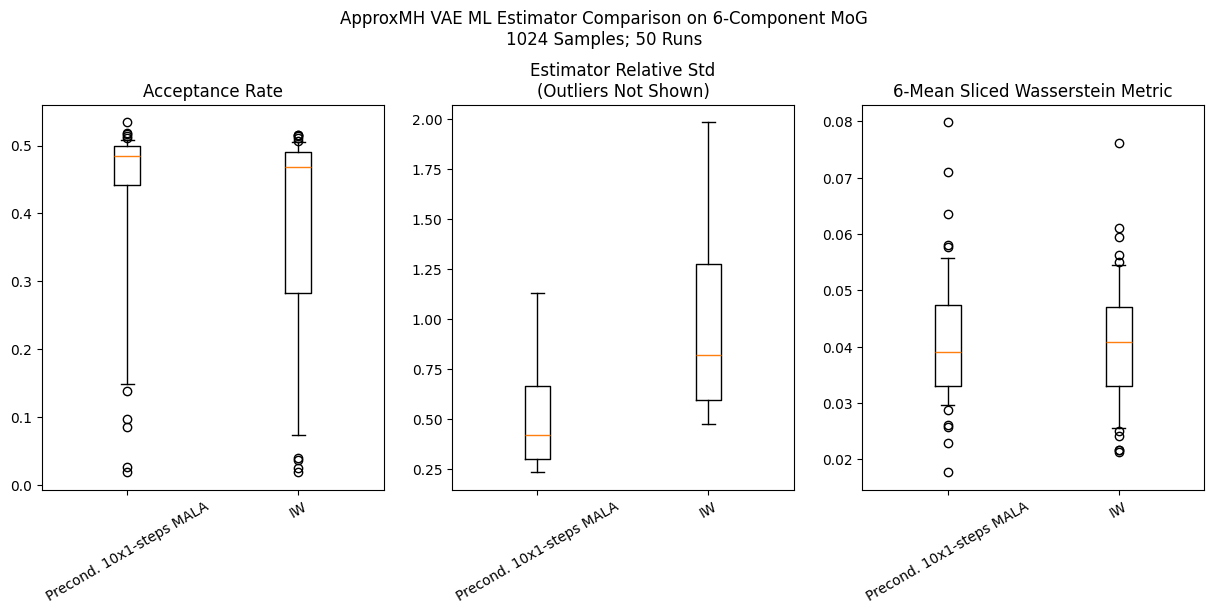

In [34]:
def compare_estimates():
    # torch.cuda.memory._record_memory_history(max_entries=100_000)
    
    # Estimator 1
    kernel_type = 'mala'
    n_kernel_steps = 1
    n_steps = 10
    n_particles = 64
    time_step = 0.8
    precondition = True
    est1 = lambda x: vae.ais_log_marginal_estimate(
        x, n_steps=n_steps, n_particles=n_particles, time_step=time_step, 
        kernel_type=kernel_type, return_acc_rate=False, resample=False,
        n_kernel_steps=n_kernel_steps,
        precondition=precondition,
        annealing_scheme='linear'
    )
    est1_name = f'{"Precond. " if precondition else ""}{n_steps}x{n_kernel_steps}-steps {kernel_type.upper()}'
    # Estimator 2
    L = n_particles
    est2 = lambda x: vae.iw_log_marginal_estimate(x, L=L, batch_L=128, return_variance=True)
    est2_name = f'IW'

    estimators = [
        (est1, est1_name),
        (est2, est2_name)
    ]
    n_ests = len(estimators)
    
    # Comparison parameters
    n_runs = 50
    n_samples = 1024
    sample_metric = SlicedDistributionMetric(WassersteinMetric1d(), 3 * D)
    # Plotting parameters
    whiskers = (10, 90)  # Box plot whisker percentiles

    target_samples = target.sample((n_samples,))
    test_logs = defaultdict(lambda: [list() for _ in range(n_ests)]) 
    
    for run_i in tqdm(range(n_runs)):
        vae_samples = vae.sample((n_samples,))
        for i in range(n_ests):
            est, est_name = estimators[i]
            log_likelihoods, variances = est(vae_samples)
            test_logs['likelihoods'][i].append(log_likelihoods.exp().detach())
            test_logs['variances'][i].append(variances.detach())
            # shuffled_vae_samples = vae_samples[torch.randperm(n_samples)]
            mh_acc_rate, mh_samples = metropolis_hastings_filter(target, vae_samples, est)
            test_logs['acc_rate'][i].append(mh_acc_rate)
            test_logs['sample_metric'][i].append(sample_metric(target_samples, vae_samples).item())

    for name in ('variances', 'likelihoods'):
        test_logs[name] = torch.stack(tuple(map(torch.cat, test_logs[name])))

    fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

    ax = axs[0]
    ax.set_title('Acceptance Rate')
    ax.boxplot(
        test_logs['acc_rate'], 
        tick_labels=[est_name for est, est_name in estimators],
        whis=whiskers
    )

    ax = axs[1]
    ax.set_title('Estimator Relative Std\n(Outliers Not Shown)')
    ax.boxplot(
        list(to_numpy(test_logs['variances'].sqrt() / test_logs['likelihoods'])), 
        tick_labels=[est_name for est, est_name in estimators],
        whis=whiskers,
        showfliers=False
    )
    # ax.set_ylim(0., 10.)

    ax = axs[2]
    ax.set_title(sample_metric.name())
    ax.boxplot(
        test_logs['sample_metric'], 
        tick_labels=[est_name for est, est_name in estimators],
        whis=whiskers,
        showfliers=True
    )

    for ax in axs:
        ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    plt.suptitle(f'ApproxMH VAE ML Estimator Comparison on {target_friendly_name}\n{n_samples} Samples; {n_runs} Runs', y=1.07)

    # torch.cuda.memory._dump_snapshot(f"bruh.pickle")

compare_estimates()

Average A/R: 0.649


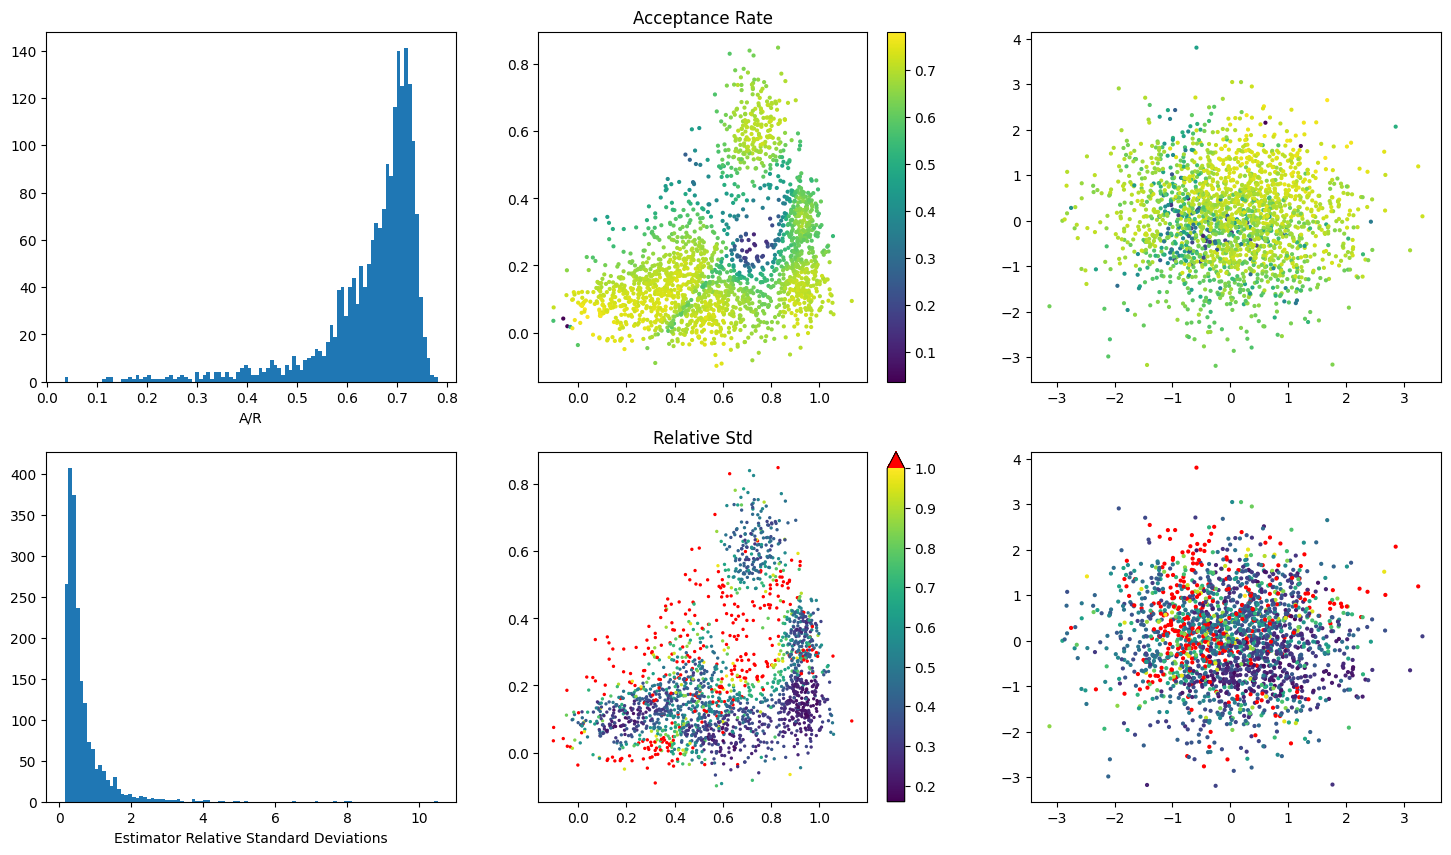

In [29]:
def analysis_by_vae_sample():
    # Estimator
    n_steps = 10
    n_particles = 128
    time_step = 0.8
    est = lambda x: vae.ais_log_marginal_estimate(
        x, n_steps=n_steps, n_particles=n_particles, time_step=time_step, 
        batch_particles=64, kernel_type='mala', resample=False,
        precondition=True
    )
    est_name = f'{n_steps}-steps {n_particles}-sample SMC MALA'

    # # # # # # # #
    n_samples = 2_000

    vae_samples_latent = vae.prior.sample((n_samples,))
    vae_samples = vae.decode(vae_samples_latent)
    # vae_samples = target.sample((n_samples,))
    log_likelihoods, variances, acc_rates = est(vae_samples,)
    rel_stds = variances.sqrt() / log_likelihoods.exp()
    reconstruction_log_probs = []
    for i in range(50):
        reconstruction_log_probs.append(vae.decoder_distribution(vae.encode(vae_samples)).log_prob(vae_samples).detach())
    reconstruction_log_prob = torch.stack(reconstruction_log_probs).logsumexp(dim=0)

    fig, axs = plt.subplots(figsize=(18, 10), ncols=3, nrows=2)
    axs = axs.flatten()

    ax = axs[0]
    ax.hist(to_numpy(acc_rates), bins=100)
    ax.set_xlabel('A/R')
    
    ax = axs[1]
    # ax.set_yscale('log')
    ax.set_title('Acceptance Rate')
    sc = ax.scatter(*pl(vae_samples), c=to_numpy(acc_rates), s=4)
    plt.colorbar(sc)

    ax = axs[2]
    ax.scatter(*pl(vae_samples_latent), c=to_numpy(acc_rates), s=4)

    ax = axs[3]
    ax.hist(to_numpy(rel_stds), bins=100)
    ax.set_xlabel('Estimator Relative Standard Deviations')
    
    ax = axs[4]
    # ax.set_yscale('log')
    ax.set_title('Relative Std')
    cmap = plt.get_cmap('viridis')
    cmap.set_over('red')
    sc = ax.scatter(*pl(vae_samples), c=to_numpy(rel_stds), cmap=cmap, vmax=1, s=2)
    plt.colorbar(sc, extend='max')

    ax = axs[5]
    ax.scatter(*pl(vae_samples_latent), c=to_numpy(rel_stds), cmap=cmap, vmax=1, s=4)

    print(f'Average A/R: {acc_rates.mean().item():0.3f}')
    

analysis_by_vae_sample()

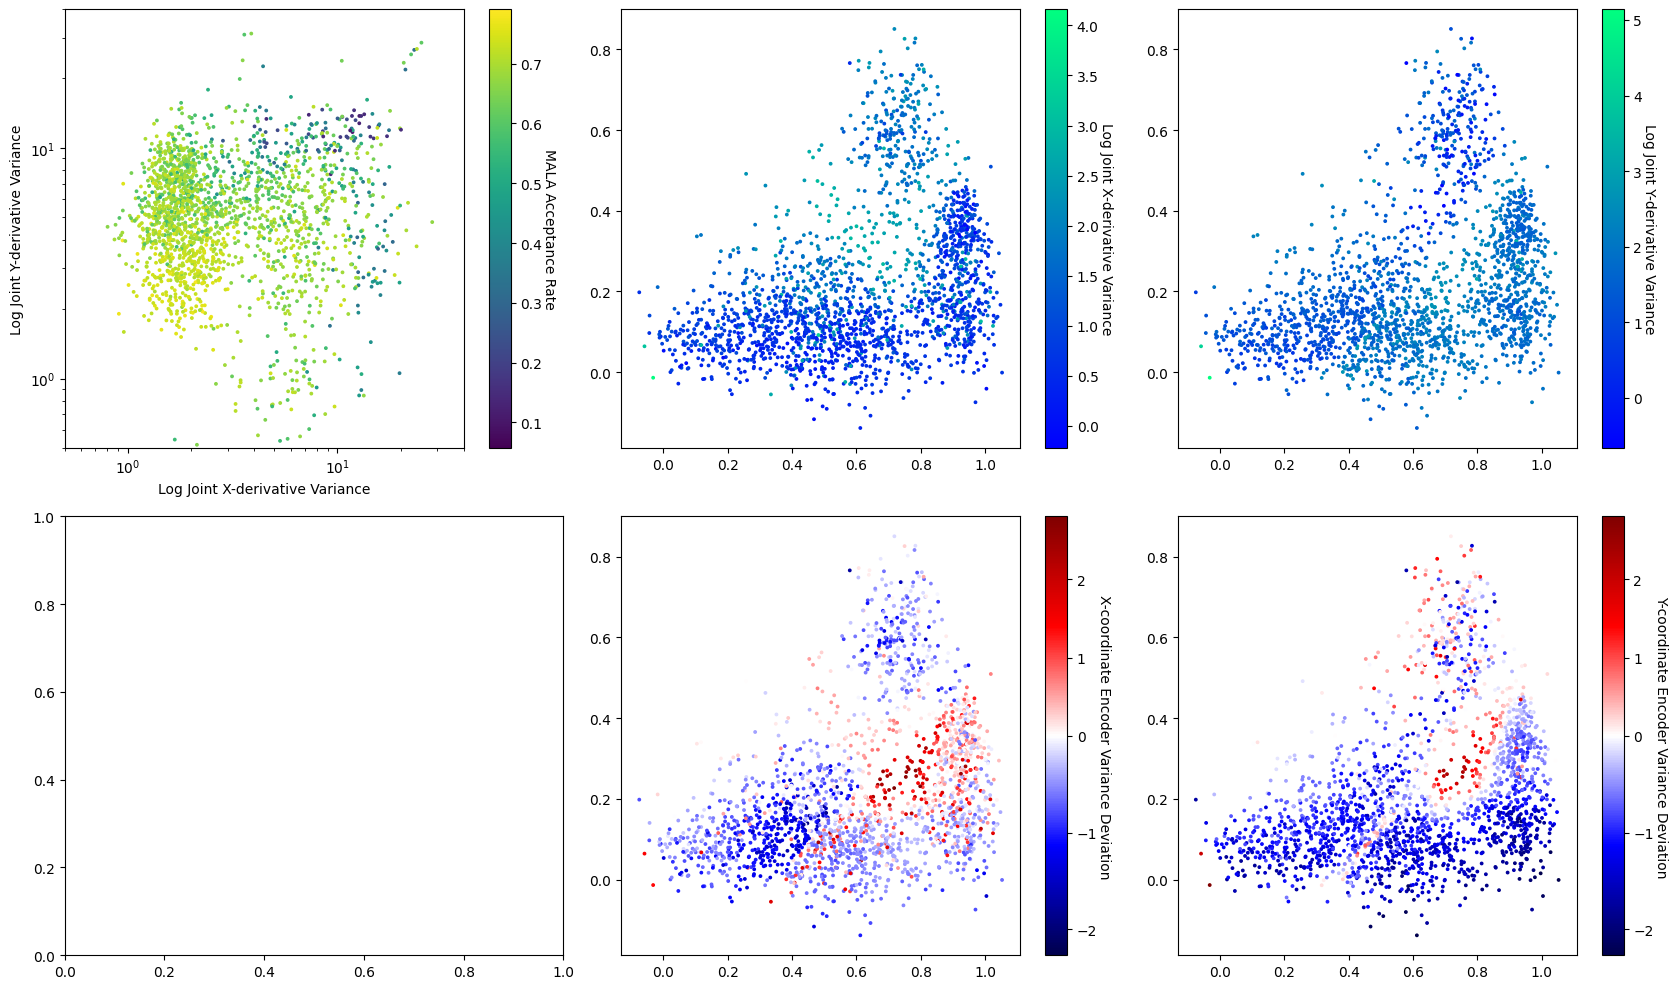

In [36]:
def posterior_condition_number():
    n_samples = 2000
    n_particles = 64
    n_steps = 10
    time_step = 0.8
    est = lambda x: vae.ais_log_marginal_estimate(
        x, n_steps=n_steps, n_particles=n_particles, time_step=time_step, 
        batch_particles=64, kernel_type='mala', resample=False,
        precondition=True
    )
    est_name = f'{n_steps}-steps {n_particles}-sample SMC MALA'

    vae_samples = vae.sample((n_samples,))
    _, log_encoder_variance = vae.encoding_parameters(vae_samples)
    encoder_samples = vae.encoder_distribution(vae_samples).sample((n_particles,)).requires_grad_(True)
    unnormalized_posteriors = vae.posterior(vae_samples)
    posterior_probs = unnormalized_posteriors.log_prob(encoder_samples)
    posterior_grads = torch.autograd.grad(posterior_probs.sum(), encoder_samples)[0]
    scales = posterior_grads.std(dim=0)

    log_likelihoods, variances, acc_rates = est(vae_samples,)
    relative_variances = variances / torch.exp(2 * log_likelihoods)

    fig, axs = plt.subplots(figsize=(17, 10), ncols=3, nrows=2)
    axs = axs.flatten()

    ax = axs[0]
    ax.set_xlabel('Log Joint X-derivative Variance')
    ax.set_ylabel('Log Joint Y-derivative Variance')
    ax.set_xscale('log')
    ax.set_yscale('log')
    xylim = (0.5, 40)
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    sc = ax.scatter(*pl(scales), s=3, c=to_numpy(acc_rates))
    cbar = plt.colorbar(sc)
    cbar.ax.set_ylabel('MALA Acceptance Rate', rotation=-90, labelpad=10.)

    ax = axs[1]
    sc1 = ax.scatter(*pl(vae_samples), s=3, c=to_numpy(scales[:, 0].log()), cmap='winter')
    cbar = plt.colorbar(sc1)
    cbar.ax.set_ylabel('Log Joint X-derivative Variance', rotation=-90, labelpad=10.)

    ax = axs[2]
    sc2 = ax.scatter(*pl(vae_samples), s=3, c=to_numpy(scales[:, 1].log()), cmap='winter')
    cbar = plt.colorbar(sc2)
    cbar.ax.set_ylabel('Log Joint Y-derivative Variance', rotation=-90, labelpad=10.)

    ax = axs[4]
    sc3 = ax.scatter(*pl(vae_samples), s=3, c=to_numpy(scales[:, 0].log() + log_encoder_variance[:, 0]), cmap='seismic', norm=mpl.colors.TwoSlopeNorm(0))
    cbar = plt.colorbar(sc3)
    cbar.ax.set_ylabel('X-coordinate Encoder Variance Deviation', rotation=-90, labelpad=10.)

    ax = axs[5]
    sc4 = ax.scatter(*pl(vae_samples), s=3, c=to_numpy(scales[:, 1].log() + log_encoder_variance[:, 1]), cmap='seismic', norm=mpl.colors.TwoSlopeNorm(0))
    cbar = plt.colorbar(sc4)
    cbar.ax.set_ylabel('Y-coordinate Encoder Variance Deviation', rotation=-90, labelpad=10.)

    # unify_clim(sc1, sc2)
    unify_clim(sc3, sc4)
    plt.tight_layout()

posterior_condition_number()

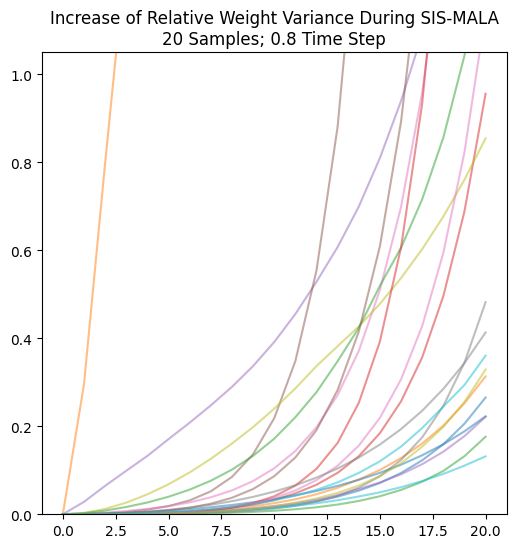

In [73]:
def sis_importance_weight_variance_dynamics():
    n_samples = 20
    n_particles = 64
    n_steps = 20
    time_step = 0.8
    kernel_type = 'mala'

    vae_samples = vae.sample((n_samples,))

    # all_weight_variances - [n_samples * (n_steps + 1)] tensor
    all_log_mean_weights, all_weight_variances = vae.ais_log_marginal_estimate(
        vae_samples, n_steps=n_steps, n_particles=n_particles, time_step=time_step, 
        kernel_type=kernel_type, resample=False, precondition=False,
        return_acc_rate=False, return_all_steps=True,
        annealing_scheme='linear',
        annealing_scale=1.
    )
    log_likelihoods = all_log_mean_weights[..., -1]
    all_relative_weight_variances = all_weight_variances / torch.exp(2 * log_likelihoods).unsqueeze(-1)
    normalized_variance_trajectories = all_weight_variances / all_weight_variances[:, -1].unsqueeze(-1)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(f'Increase of Relative Weight Variance During SIS-{kernel_type.upper()}\n{n_samples} Samples; {time_step} Time Step')

    ax.plot(np.arange(n_steps + 1), to_numpy(all_relative_weight_variances.T), alpha=0.5)
    ax.set_ylim(0, 1.05)

sis_importance_weight_variance_dynamics()

Local A/R in LG: 0.671


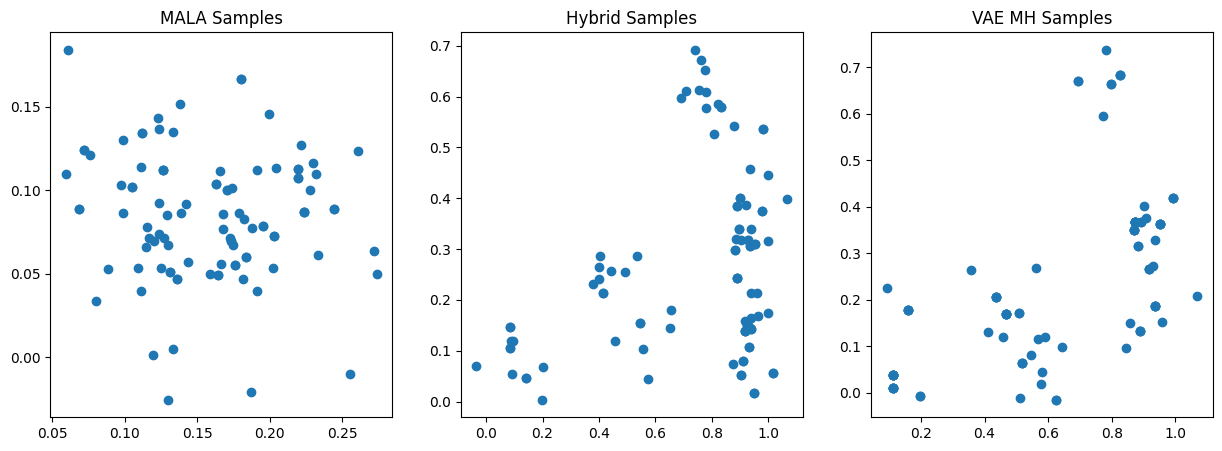

In [93]:
def test_local_global():
    n_steps = 10
    n_particles = 128
    time_step = 0.8
    est = lambda x: vae.ais_log_marginal_estimate(
        x, n_steps=n_steps, n_particles=n_particles, time_step=time_step, 
        batch_particles=64, kernel_type='mala', resample=False,
        precondition=True, return_acc_rate=False
    )[0]
    n_samples = 100

    n_local_steps=5
    n_isir_particles=10
    local_step_size = 0.002
    lg_sampler = LocalGlobalSampler(
        target=target,
        D=D,
        global_model=vae,
        model_log_likelihood_estimate=est,
        n_local_steps=n_local_steps,
        n_isir_particles=n_isir_particles,
        local_step_size=local_step_size,
        device=device
    )
    local_kernel = LangevinKernel(target, local_step_size, mh_corrected=True)

    vae_samples = vae.sample((n_samples,))
    global_ar, global_samples = metropolis_hastings_filter(target, vae_samples, est)

    local_samples = [torch.zeros(D, device=device)]
    for i in range(n_samples):
        local_samples.append(local_kernel.step(local_samples[-1], return_acc_prob=False))
    local_samples = torch.stack(local_samples[1:])

    lg_samples, lg_ar = lg_sampler.sample(n_samples)

    fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

    ax = axs[0]
    ax.set_title('MALA Samples')
    ax.scatter(*pl(local_samples))

    ax = axs[1]
    ax.set_title('Hybrid Samples')
    ax.scatter(*pl(lg_samples))

    ax = axs[2]
    ax.set_title('VAE MH Samples')
    ax.scatter(*pl(global_samples))

    print(f'Local A/R in LG: {lg_ar.item():0.3f}')

test_local_global()